# 4.1 プロンプトエンジニアリングによる質問応答

本Notebookでは、文章生成AIを用いて質問応答を実行するコードを記載します。

## 事前準備

ライブラリのインストール、データセットの準備、モデルの読み込みを実施します。

### (1) ライブラリのインストール

使用するライブラリをインストールします。

In [ ]:
!pip install transformers==4.34.0
!pip install accelerate==0.23.0
!pip install datasets==2.15.0
!pip install langchain==0.0.345
!pip install bitsandbytes==0.41.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 104.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 45.0 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.2
    Uninstalling tokenizers-0.15.2:
      Successfully uninstalled tokenizers-0.15.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 72.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/82

In [ ]:
import warnings
warnings.simplefilter("ignore")

### (2) データセットの準備

使用するデータセットをダウンロードします。

In [ ]:
from datasets import load_dataset

dataset = load_dataset("shunk031/JGLUE", name="JCommonsenseQA")
dataset

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['q_id', 'question', 'choice0', 'choice1', 'choice2', 'choice3', 'choice4', 'label'],
        num_rows: 8939
    })
    validation: Dataset({
        features: ['q_id', 'question', 'choice0', 'choice1', 'choice2', 'choice3', 'choice4', 'label'],
        num_rows: 1119
    })
})

In [ ]:
dataset["train"][0]

{'q_id': 0,
 'question': '主に子ども向けのもので、イラストのついた物語が書かれているものはどれ？',
 'choice0': '世界',
 'choice1': '写真集',
 'choice2': '絵本',
 'choice3': '論文',
 'choice4': '図鑑',
 'label': 2}

### (3) モデルの読み込み

使用するモデルを読み込みます。

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# トークナイザ・モデルを読み込みます
tokenizer = AutoTokenizer.from_pretrained("llm-jp/llm-jp-13b-v1.0", use_fast=True)
model = AutoModelForCausalLM.from_pretrained(
    "llm-jp/llm-jp-13b-v1.0",
    load_in_8bit=True, # 計算を効率化させるため、重みをint8として読み込みます。
    device_map="auto"
)

tokenizer_config.json:   0%|          | 0.00/529 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.25M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/331 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/793 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/36.3k [00:00<?, ?B/s]

pytorch_model-00001-of-00003.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

pytorch_model-00002-of-00003.bin:   0%|          | 0.00/9.86G [00:00<?, ?B/s]

pytorch_model-00003-of-00003.bin:   0%|          | 0.00/5.87G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

## プロンプトの実装

### (1) 回答を生成する

まずは、試しに文章生成を実行します。

In [ ]:
prompt = "日本で一番高い山は？\n\n"
prompt = prompt + "### 回答：\n"

# トークナイズします
tokenized_input = tokenizer.encode(
    prompt,
    add_special_tokens=False,
    return_tensors="pt"
).to(model.device)

# モデルに入力し、出力を取得します
with torch.no_grad():
    output = model.generate(
        tokenized_input,
        max_new_tokens=20,
        top_p=0.95,
        do_sample=True,
        temperature=0.7
    )[0]
print(tokenizer.decode(output))


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:7 for open-end generation.


日本で一番高い山は？

### 回答：

日本の最高峰は、富士山です。

富士山は、標高3,776


### (2) 回答生成パイプライン

入力を簡単にするため、回答生成パイプラインを実装します。

In [ ]:
from transformers import pipeline


# パイプラインの構築
qa_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id
)

prompt = "日本で一番高い山は？\n\n"
prompt = prompt + "### 回答：\n"

generate_text = qa_pipeline(
    prompt,
    max_length=50,
    num_return_sequences=1,
    temperature=0
)[0]["generated_text"]
print(generate_text)

日本で一番高い山は？

### 回答：

富士山

### 解説：

富士山は日本で一番高い山である。

## 日本で一番高い山は


#### zero-shot

In [ ]:
prompt = """
### 指示:
質問と選択肢を入力として、選択肢から回答を出力してください。また、回答は選択肢から１つを選択し、番号で回答してください。数値で回答し、他の文字は含めないでください。

### 入力:
質問:
火を起こすとあらわれるもくもくするものは？
選択肢:
0.歯の変色 1.ガス 2.中毒 3.爆発 4.煙

### 回答:
"""

generate_text = qa_pipeline(
    prompt,
    max_length=50,
    num_return_sequences=1,
    temperature=0,
    return_full_text=True
)[0]["generated_text"]

print(generate_text)



### 指示:
質問と選択肢を入力として、選択肢から回答を出力してください。また、回答は選択肢から１つを選択し、番号で回答してください。数値で回答し、他の文字は含めないでください。

### 入力:
質問:
火を起こすとあらわれるもくもくするものは？
選択肢:
0.歯の変色 1.ガス 2.中毒 3.爆発 4.煙

### 回答:
1


#### one-shot

In [ ]:
prompt = """
### 指示:
質問と選択肢を入力として、選択肢から回答を出力してください。また、回答は選択肢から１つを選択し、番号で回答してください。数値で回答し、他の文字は含めないでください。

### 入力:
質問:
主に子ども向けのもので、イラストのついた物語が書かれているものはどれ？
選択肢:
0.世界 1.写真集 2.絵本 3.論文 4.図鑑

### 回答:
2

### 入力:
質問:
火を起こすとあらわれるもくもくするものは？
選択肢:
0.歯の変色 1.ガス 2.中毒 3.爆発 4.煙

### 回答:
"""

generate_text = qa_pipeline(
    prompt,
    max_length=50,
    num_return_sequences=1,
    temperature=0,
    return_full_text=True
)[0]["generated_text"]

print(generate_text)



### 指示:
質問と選択肢を入力として、選択肢から回答を出力してください。また、回答は選択肢から１つを選択し、番号で回答してください。数値で回答し、他の文字は含めないでください。

### 入力:
質問:
主に子ども向けのもので、イラストのついた物語が書かれているものはどれ？
選択肢:
0.世界 1.写真集 2.絵本 3.論文 4.図鑑

### 回答:
2

### 入力:
質問:
火を起こすとあらわれるもくもくするものは？
選択肢:
0.歯の変色 1.ガス 2.中毒 3.爆発 4.煙

### 回答:
3


#### few-shot

In [ ]:
prompt = """
### 指示:
質問と選択肢を入力として、選択肢から回答を出力してください。また、回答は選択肢から１つを選択し、番号で回答してください。数値で回答し、他の文字は含めないでください。

### 入力:
質問:
主に子ども向けのもので、イラストのついた物語が書かれているものはどれ？
選択肢:
0.世界 1.写真集 2.絵本 3.論文 4.図鑑

### 回答:
2

### 入力:
質問:
未成年者を監護・教育し，彼らを監督し，彼らの財産上の利益を守る法律上の義務をもつ人は？
選択肢:
0.浮浪者 1.保護者 2.お坊さん 3.宗教者 4.預言者

### 回答:
1

### 入力:
質問:
数字の１を表すときに使う体は？
選択肢:
0.胸 1.肉球 2.背中 3.人差し指 4.親指

### 回答:
3

### 入力:
質問:
火を起こすとあらわれるもくもくするものは？
選択肢:
0.歯の変色 1.ガス 2.中毒 3.爆発 4.煙

### 回答:
"""

generate_text = qa_pipeline(
    prompt,
    max_length=50,
    num_return_sequences=1,
    temperature=0,
    return_full_text=True
)[0]["generated_text"]

print(generate_text)



### 指示:
質問と選択肢を入力として、選択肢から回答を出力してください。また、回答は選択肢から１つを選択し、番号で回答してください。数値で回答し、他の文字は含めないでください。

### 入力:
質問:
主に子ども向けのもので、イラストのついた物語が書かれているものはどれ？
選択肢:
0.世界 1.写真集 2.絵本 3.論文 4.図鑑

### 回答:
2

### 入力:
質問:
未成年者を監護・教育し，彼らを監督し，彼らの財産上の利益を守る法律上の義務をもつ人は？
選択肢:
0.浮浪者 1.保護者 2.お坊さん 3.宗教者 4.預言者

### 回答:
1

### 入力:
質問:
数字の１を表すときに使う体は？
選択肢:
0.胸 1.肉球 2.背中 3.人差し指 4.親指

### 回答:
3

### 入力:
質問:
火を起こすとあらわれるもくもくするものは？
選択肢:
0.歯の変色 1.ガス 2.中毒 3.爆発 4.煙

### 回答:
2


### (3) プロンプトテンプレートの作成

データセットを同一フォーマットにするためのプロンプトテンプレートを作成します。

In [ ]:
# 推論用にデータセット前処理
def add_text(example):
    example["input"] = f"質問:\n{example['question']}\n選択肢:\n0.{example['choice0']} 1.{example['choice1']} 2.{example['choice2']} 3.{example['choice3']} 4.{example['choice4']}"
    return example

dataset = dataset.map(add_text)
print(dataset["train"]["input"][0])


Map:   0%|          | 0/8939 [00:00<?, ? examples/s]

Map:   0%|          | 0/1119 [00:00<?, ? examples/s]

質問:
主に子ども向けのもので、イラストのついた物語が書かれているものはどれ？
選択肢:
0.世界 1.写真集 2.絵本 3.論文 4.図鑑


In [ ]:
from langchain.prompts.prompt import PromptTemplate


example_prompt = PromptTemplate(
    input_variables=["input", "label"],
    template="### 入力:\n{input}\n\n### 回答:\n{label}" # プロンプトテンプレート文
)

prompt = example_prompt.format(
    input=dataset["train"]["input"][0],
    label=dataset["train"]["label"][0]
)
print(prompt)

### 入力:
質問:
主に子ども向けのもので、イラストのついた物語が書かれているものはどれ？
選択肢:
0.世界 1.写真集 2.絵本 3.論文 4.図鑑

### 回答:
2


### (4) few-shotプロンプトテンプレートの作成

few-shotプロンプト用のテンプレートを作成します。

In [ ]:
from langchain.prompts.few_shot import FewShotPromptTemplate


instruction_text = "### 指示:\n質問と選択肢を入力として、選択肢から回答を出力してください。また、回答は選択肢から１つを選択し、番号で回答してください。数値で回答し、他の文字は含めないでください。"

# few-shotサンプルを取得する
num_shots = 2
examples = []
for i in range(num_shots):
    examples.append(dataset["train"][i])

# 予測対象のデータを取得する
test_prompt = example_prompt.format(input=dataset["validation"]["input"][0], label="")

prompt = FewShotPromptTemplate(
    examples=examples,
    example_prompt=example_prompt,
    input_variables=["input", "label"],
    prefix=instruction_text, # 指示文を先頭に追加する
    suffix=test_prompt # 予測対象を末尾に追加する
)
print(prompt.format())

### 指示:
質問と選択肢を入力として、選択肢から回答を出力してください。また、回答は選択肢から１つを選択し、番号で回答してください。数値で回答し、他の文字は含めないでください。

### 入力:
質問:
主に子ども向けのもので、イラストのついた物語が書かれているものはどれ？
選択肢:
0.世界 1.写真集 2.絵本 3.論文 4.図鑑

### 回答:
2

### 入力:
質問:
未成年者を監護・教育し，彼らを監督し，彼らの財産上の利益を守る法律上の義務をもつ人は？
選択肢:
0.浮浪者 1.保護者 2.お坊さん 3.宗教者 4.預言者

### 回答:
1

### 入力:
質問:
電子機器で使用される最も主要な電子回路基板の事をなんと言う？
選択肢:
0.掲示板 1.パソコン 2.マザーボード 3.ハードディスク 4.まな板

### 回答:



In [ ]:
# クラス化
class QADataset():
    def __init__(
        self,
        dataset,
        instruction_text,
        example_prompt,
        input_variables,
        num_shots
    ):
        self.dataset_train = dataset["train"]
        self.dataset_test = dataset["validation"]
        self.instruction_text = instruction_text
        self.example_prompt = example_prompt
        self.input_variables = input_variables
        self.num_shots = num_shots

        self.examples = []
        for i in range(self.num_shots):
            self.examples.append(self.dataset_train[i])

    def __len__(self):
        return len(self.dataset_test)

    def __getitem__(self, rowid):
        if rowid > self.__len__():
            raise ValueError(f"rowid must be less than {self.__len__()}")

        test_data = self.dataset_test[rowid]
        test_prompt = self.example_prompt.format(
            input=test_data["input"],
            label=""
        )
        prompt = FewShotPromptTemplate(
            examples=self.examples,
            example_prompt=self.example_prompt,
            input_variables=self.input_variables,
            prefix=self.instruction_text,
            suffix=test_prompt
        )

        return prompt.format()

qa_fewshot_dataset = QADataset(
    dataset=dataset,
    instruction_text=instruction_text,
    example_prompt=example_prompt,
    input_variables=["input", "label"],
    num_shots=2
)

print(qa_fewshot_dataset[0])

### 指示:
質問と選択肢を入力として、選択肢から回答を出力してください。また、回答は選択肢から１つを選択し、番号で回答してください。数値で回答し、他の文字は含めないでください。

### 入力:
質問:
主に子ども向けのもので、イラストのついた物語が書かれているものはどれ？
選択肢:
0.世界 1.写真集 2.絵本 3.論文 4.図鑑

### 回答:
2

### 入力:
質問:
未成年者を監護・教育し，彼らを監督し，彼らの財産上の利益を守る法律上の義務をもつ人は？
選択肢:
0.浮浪者 1.保護者 2.お坊さん 3.宗教者 4.預言者

### 回答:
1

### 入力:
質問:
電子機器で使用される最も主要な電子回路基板の事をなんと言う？
選択肢:
0.掲示板 1.パソコン 2.マザーボード 3.ハードディスク 4.まな板

### 回答:



### (5) 回答を出力する

回答のみを出力するようにします。正しく数値が出力されない場合は`-1`を出力します。

In [ ]:
def predict(qa_pipeline, prompt):
    answer = qa_pipeline(
        prompt,
        max_length=50,
        num_return_sequences=1,
        temperature=0,
        return_full_text=False # return_full_textをFalseにすることで、生成AIの出力のみを表示できます。
    )[0]["generated_text"]

    try:
      return int(answer[0])
    except ValueError:
      return -1

predict(qa_pipeline, qa_fewshot_dataset[0])


2

## 評価

In [ ]:
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score

### (1) zero-shot

zero-shotプロンプトの精度評価を実施します。

In [ ]:
# データセット作成
zero_shot_dataset = QADataset(
    dataset=dataset,
    instruction_text=instruction_text,
    example_prompt=example_prompt,
    input_variables=["input", "label"],
    num_shots=0
)

# 予測
y_true = np.array(dataset["validation"]["label"])
y_preds_zero_shot = []
for i in tqdm(range(len(zero_shot_dataset))):
    y_preds_zero_shot.append(predict(qa_pipeline, zero_shot_dataset[i]))
y_preds_zero_shot = np.array(y_preds_zero_shot)

# 精度評価
print(f"\naccuracy : {accuracy_score(y_true, y_preds_zero_shot):.3f}")

100%|██████████| 1119/1119 [04:05<00:00,  4.56it/s]


accuracy : 0.128


### (2) one-shot

one-shotプロンプトの精度評価を実施します。

In [ ]:
# データセット作成
one_shot_dataset = QADataset(
    dataset=dataset,
    instruction_text=instruction_text,
    example_prompt=example_prompt,
    input_variables=["input", "label"],
    num_shots=1
)

# 予測
y_true = np.array(dataset["validation"]["label"])
y_preds_one_shot = []
for i in tqdm(range(len(one_shot_dataset))):
    y_preds_one_shot.append(predict(qa_pipeline, one_shot_dataset[i]))
y_preds_one_shot = np.array(y_preds_one_shot)

# 精度評価
print(f"\naccuracy : {accuracy_score(y_true, y_preds_one_shot):.3f}")

100%|██████████| 1119/1119 [04:08<00:00,  4.50it/s]


accuracy : 0.243


### (3) few-shot

few-shotプロンプトの精度評価を実施します。

In [ ]:
# データセット作成
few_shot_dataset = QADataset(
    dataset=dataset,
    instruction_text=instruction_text,
    example_prompt=example_prompt,
    input_variables=["input", "label"],
    num_shots=3
)

# 予測
y_true = np.array(dataset["validation"]["label"])
y_preds_few_shot = []
for i in tqdm(range(len(few_shot_dataset))):
    y_preds_few_shot.append(predict(qa_pipeline, few_shot_dataset[i]))
y_preds_few_shot = np.array(y_preds_few_shot)

# 精度評価
print(f"\naccuracy : {accuracy_score(y_true, y_preds_few_shot):.3f}")

100%|██████████| 1119/1119 [04:12<00:00,  4.43it/s]


accuracy : 0.219


### (4) 評価のまとめ

精度評価の際に推論したラベルをまとめてグラフにします。

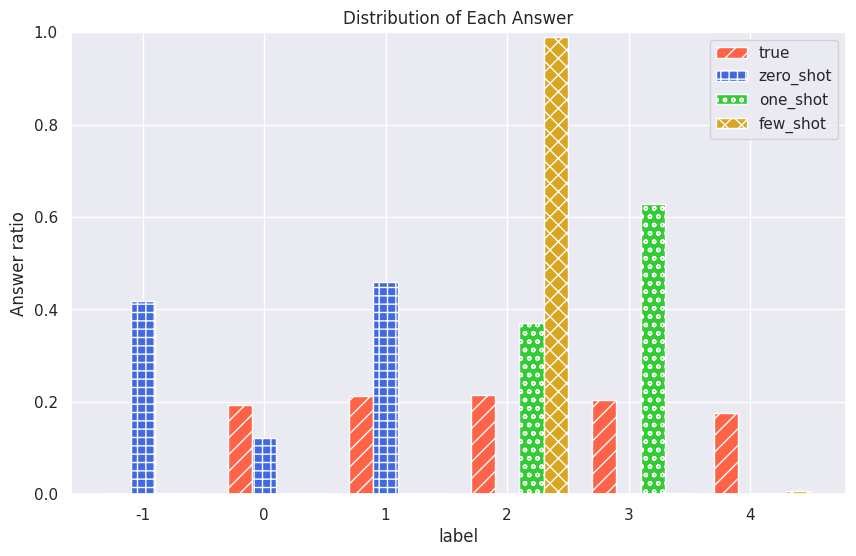

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

# データフレームに格納
df = pd.DataFrame({
    "true": y_true,
    "zero_shot": y_preds_zero_shot,
    "one_shot": y_preds_one_shot,
    "few_shot": y_preds_few_shot
}).astype(str)

# データ整形
melt_df = df.melt(var_name="category", value_name="label")

# ラベル数取得
order = ["-1", "0", "1", "2", "3", "4"]
categories = melt_df["category"].unique()
counts = melt_df.groupby(["category", "label"]).size().unstack(fill_value=0)
counts = counts.reindex(columns=order, fill_value=0)
ratio = (counts.T / counts.sum(axis=1)).T

# プロット
plt.figure(figsize=(10, 6))
bar_width = 0.2
positions = np.arange(len(order))
colors = ["tomato", "royalblue", "limegreen", "goldenrod"]
hatches = ["//", "++", "oo", "xx"]
for i, category in enumerate(categories):
    plt.bar(positions + i * bar_width, ratio.loc[category, order], bar_width, label=category, color=colors[i % len(colors)], hatch=hatches[i % len(hatches)])

plt.title("Distribution of Each Answer")
plt.xlabel("label")
plt.ylabel("Answer ratio")
plt.ylim([0, 1])
plt.xticks(positions + bar_width, order)
plt.legend()
plt.show()